In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

In [18]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES = "../data/driver_genes"
DRIVER_COUNTS = "../data/driver_count_by_cancer_subtype"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
CLINICAL_DATA = "../data/datasets/PCAWG/clinical_data/pcawg_donor_clinical_data.csv"
SURVIVAL_DATA = "../data/datasets/TCGA/TCGA_survival_outcome.csv"
CANCER_GENE_TYPES = "../metadata/cancer_genes.tsv"

# output files/ directories
HAZARD_PLOTS = "../results/hazard_plots"
os.makedirs(HAZARD_PLOTS, exist_ok=True)
PLOT_DATA_DIR = "../plot_data/cox_hazard_models"
os.makedirs(PLOT_DATA_DIR, exist_ok=True)
    
CANCER_TYPES = os.listdir(DRIVER_GENES) # cancer types with driver genes
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
CANCER_TYPES.remove("Pancancer")
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Myeloid-MPN', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [19]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [20]:
# get all mutations in driver genes
tumor_mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	tumor_mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
	driver_genes = pd.read_csv(os.path.join(DRIVER_GENES, cancer_type + ".tsv"), sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	tumor_mut_cancer_df = tumor_mut_cancer_df[tumor_mut_cancer_df["gene"].isin(driver_genes_list)]
	tumor_mut_cancer_df = pd.merge(tumor_mut_cancer_df, driver_genes[["gene", "gene_length"]], on="gene", how="left")

	# get genome-wide mutation data
	genome_wide_mutations = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")
	tumor_mut_cancer_df = pd.merge(tumor_mut_cancer_df, genome_wide_mutations, on=["Tumor_Sample_Barcode"], how="left")
	tumor_mut_cancer_df["cancer_type"] = cancer_type

	# driver counts
	driver_counts = pd.read_csv(f"{DRIVER_COUNTS}/{cancer_type}.tsv", sep="\t")
	tumor_mut_cancer_df = pd.merge(tumor_mut_cancer_df, driver_counts, left_on="Tumor_Sample_Barcode", right_on="sample_id", how="left")
	
	tumor_mut_df = pd.concat([tumor_mut_df, tumor_mut_cancer_df], ignore_index=True)

print(tumor_mut_df.shape)
# filter out samples that are not in the whitelist
tumor_mut_df = tumor_mut_df[tumor_mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(tumor_mut_df.shape)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98671/3197953548.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tumor_mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98671/3197953548.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tumor_mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98671/3197953548.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  tumor_mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98671/3197953548.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  

(90258, 19)
(82512, 19)


In [21]:
# get clinical data
clinical_data_df = pd.read_csv(CLINICAL_DATA)
clinical_data_df = clinical_data_df[["icgc_donor_id", "submitted_donor_id", "donor_sex"]]
clinical_data_df = clinical_data_df.rename(columns={
    "icgc_donor_id": "Patient_ID", 
    "submitted_donor_id": "bcr_patient_barcode"
})
clinical_data_df.dropna(inplace=True)
clinical_data_df.drop_duplicates(inplace=True)
print(clinical_data_df.shape)

(2809, 3)


In [22]:
# get survival outcomes data
survival_data_df = pd.read_csv(SURVIVAL_DATA)
survival_data_df.reset_index(inplace=True)
survival_data_df.drop(columns=["index", "Unnamed: 0"], inplace=True)
print(survival_data_df.shape)

(11160, 33)


In [23]:
# merge tumor data with clinical data
tumor_data_merged_df = pd.merge(tumor_mut_df, clinical_data_df, on="Patient_ID", how="left")
print(tumor_data_merged_df.shape)

# merge tumor data with survival data
tumor_survival_data_merged_df = pd.merge(tumor_data_merged_df, survival_data_df, on="bcr_patient_barcode", how="left")
print(tumor_survival_data_merged_df.shape)

(82512, 21)
(82512, 53)


## Hazard Model

In [43]:
event = "PFI"
event_time  = f"{event}.time"

# tumor samples for which we have survival data
tumor_survival_data_merged_df.dropna(subset=[event, event_time], inplace=True)
print(tumor_survival_data_merged_df.shape)

# mutation density by driver status
tumor_OS_df = tumor_survival_data_merged_df[~tumor_survival_data_merged_df["driver"]]
tumor_OS_mut_density = tumor_OS_df.groupby(["Tumor_Sample_Barcode", "gene", "has_driver"]).agg({
    "mutation": "count",
    event: "first",
    event_time: "first",
    "num_drivers": "first",
    "cancer_type": "first",
    "age_at_initial_pathologic_diagnosis": "first",
    "donor_sex": "first",
    "cna_burden": "first",
    "total_mutations": "first",
}).reset_index()
tumor_OS_mut_density.rename(columns={
    "mutation": "num_passengers",
	"age_at_initial_pathologic_diagnosis": "age_at_diagnosis",
    "donor_sex": "sex",
}, inplace=True)
tumor_OS_mut_density.head()

(36659, 53)


,Tumor_Sample_Barcode,gene,has_driver,num_passengers,PFI,PFI.time,num_drivers,cancer_type,age_at_diagnosis,sex,cna_burden,total_mutations
0,00aa769d-622c-433e-8a8a-63fb5c41ea42,APC,True,8,0.0,255.0,18.0,ColoRect-AdenoCA,31.0,male,9.697974,237798
1,00aa769d-622c-433e-8a8a-63fb5c41ea42,ATM,True,8,0.0,255.0,18.0,ColoRect-AdenoCA,31.0,male,9.697974,237798
2,00aa769d-622c-433e-8a8a-63fb5c41ea42,FBXW7,False,11,0.0,255.0,18.0,ColoRect-AdenoCA,31.0,male,9.697974,237798
3,00aa769d-622c-433e-8a8a-63fb5c41ea42,KRAS,True,4,0.0,255.0,18.0,ColoRect-AdenoCA,31.0,male,9.697974,237798
4,00aa769d-622c-433e-8a8a-63fb5c41ea42,PIK3CA,True,4,0.0,255.0,18.0,ColoRect-AdenoCA,31.0,male,9.697974,237798


In [44]:
cancer_types = tumor_OS_mut_density.groupby("cancer_type").agg({
    "Tumor_Sample_Barcode": "nunique",
}).reset_index()
cancer_types.rename(columns={
	"Tumor_Sample_Barcode": "num_samples",
}, inplace=True)
cancer_types.sort_values("num_samples", ascending=False, inplace=True)
cancer_types.reset_index(drop=True, inplace=True)
print(cancer_types.shape)
cancer_types

(21, 2)


,cancer_type,num_samples
0,Breast-AdenoCa,84
1,Kidney-RCC,69
2,Liver-HCC,53
3,ColoRect-AdenoCA,52
4,Lung-SCC,47
5,Uterus-AdenoCA,44
6,Head-SCC,43
7,Ovary-AdenoCA,38
8,Skin-Melanoma,37
9,Stomach-AdenoCA,35


In [45]:
cancer_type = "Liver-HCC"
patient_data = tumor_OS_mut_density[(tumor_OS_mut_density["cancer_type"] == cancer_type)]
patient_data = patient_data[["Tumor_Sample_Barcode", event, event_time, "age_at_diagnosis", "sex", "num_drivers", "cna_burden", "total_mutations"]]
patient_data["sex"] = patient_data["sex"].apply(lambda x: 0 if x == "female" else 1)
patient_data.dropna(inplace=True)
print(patient_data.shape)
patient_data.drop_duplicates(inplace=True)
print(patient_data.shape)

(166, 8)
(50, 8)


In [46]:
gene_data = tumor_OS_mut_density[(tumor_OS_mut_density["cancer_type"] == cancer_type)]
gene_data = gene_data[["Tumor_Sample_Barcode", "gene", "num_passengers", "has_driver", "total_mutations"]]
gene_data.drop(columns=["total_mutations"], inplace=True)
print(gene_data.shape)
gene_data.dropna(inplace=True)
print(gene_data.shape)

# genes with atleast 10 samples having passenger mutations
gene_mut_count = gene_data[gene_data["num_passengers"] > 0].groupby("gene").agg({
    "Tumor_Sample_Barcode": "nunique",
    
}).reset_index()
gene_mut_count.rename(columns={
	"Tumor_Sample_Barcode": "num_samples",
}, inplace=True)
gene_list = gene_mut_count[gene_mut_count["num_samples"] >= 10]["gene"].tolist()
print(len(gene_list), gene_list)
gene_data = gene_data[gene_data["gene"].isin(gene_list)]

gene_data["has_driver"] = gene_data["has_driver"].apply(lambda x: 1 if x else 0)
gene_data = gene_data.pivot(index="Tumor_Sample_Barcode", columns="gene", values=["num_passengers", "has_driver"])
gene_data.columns = [f"{col[1]}_{col[0]}" for col in gene_data.columns]
gene_data.reset_index(inplace=True)
gene_data.fillna(0, inplace=True)
gene_data.drop_duplicates(inplace=True)
print(gene_data.shape)
gene_data.head()
gene_mut_count

(173, 4)
(173, 4)
6 ['APC', 'ARID1A', 'ARID2', 'CSMD3', 'NFE2L2', 'RB1']
(53, 13)


,gene,num_samples
0,APC,20
1,ARID1A,10
2,ARID2,18
3,AXIN1,5
4,CSMD3,53
5,CTNNB1,9
6,KEAP1,2
7,NFE2L2,21
8,RANBP2,6
9,RB1,14


In [47]:
model_data = pd.merge(patient_data, gene_data, on="Tumor_Sample_Barcode", how="left")
model_data.drop(columns=["Tumor_Sample_Barcode"], inplace=True)
print(model_data.shape)
# remove columns that have same value for all rows
model_data = model_data.loc[:, (model_data != model_data.iloc[0]).any()]
print(model_data.shape)
model_data.head()

(50, 19)
(50, 14)


,PFI,PFI.time,age_at_diagnosis,sex,num_drivers,cna_burden,total_mutations,APC_num_passengers,ARID1A_num_passengers,ARID2_num_passengers,CSMD3_num_passengers,NFE2L2_num_passengers,RB1_num_passengers,ARID1A_has_driver
0,1.0,430.0,77.0,1,6.0,42.948840,9597,1.0,0.0,0.0,8.0,0.0,0.0,0.0
1,1.0,320.0,73.0,1,4.0,31.918422,8333,1.0,0.0,0.0,21.0,0.0,1.0,0.0
2,0.0,585.0,61.0,1,8.0,14.836100,18071,1.0,1.0,0.0,6.0,4.0,2.0,0.0
3,1.0,102.0,26.0,0,4.0,97.320292,10197,0.0,1.0,0.0,12.0,2.0,1.0,0.0
4,1.0,144.0,67.0,1,6.0,47.476117,16750,0.0,1.0,2.0,15.0,0.0,0.0,0.0


In [48]:
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(model_data, duration_col = event_time, event_col = event)
cph.print_summary()

# save cph summary to a tsv file
cph_summary = cph.summary.reset_index()
cph_summary.rename(columns={"index": "variable"}, inplace=True)
cph_summary.to_csv(f"{PLOT_DATA_DIR}/{cancer_type}_{event}.tsv", sep="\t", index=False)

<lifelines.CoxPHFitter: fitted with 50 total observations, 27 right-censored observations>
             duration col = 'PFI.time'
                event col = 'PFI'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 50
number of events observed = 23
   partial log-likelihood = -56.34
         time fit was run = 2026-01-12 21:21:55 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
age_at_diagnosis      -0.05      0.95      0.02           -0.09           -0.01                0.91                0.99
sex                   -1.19      0.31      0.58           -2.33           -0.04                0.10                0.96
num_drivers            0.14      1.15      0.10           -0.05            0.33                0.95                1.40
cna_burden             0.01      1.01      0.01           -0.01            0.02                0.99                1.02
total_mutations       -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
APC_num_passengers    -0.11      0.90      0.52           -1.12            0.91                0.33                2.48
ARID1A_num_passengers  0.50      1.65      0.75           -0.97            1.98                0.38                7.24
ARID2_num_passengers   1.87      6.49      0.57            0.76            2.98                2.14               19.70
CSMD3_num_passengers   0.13      1.14      0.05            0.03            0.23                1.04                1.26
NFE2L2_num_passengers  0.31      1.36      0.35           -0.38            1.00                0.68                2.73
RB1_num_passengers    -0.15      0.86      0.45           -1.04            0.74                0.35                2.09
ARID1A_has_driver      0.00      1.00    100.00         -196.00          196.00                0.00            1.32e+85

                       cmp to     z      p  -log2(p)
covariate                                           
age_at_diagnosis         0.00 -2.42   0.02      6.02
sex                      0.00 -2.03   0.04      4.57
num_drivers              0.00  1.45   0.15      2.78
cna_burden               0.00  0.95   0.34      1.55
total_mutations          0.00 -2.17   0.03      5.05
APC_num_passengers       0.00 -0.21   0.84      0.26
ARID1A_num_passengers    0.00  0.67   0.50      0.99
ARID2_num_passengers     0.00  3.30 <0.005     10.01
CSMD3_num_passengers     0.00  2.65   0.01      6.94
NFE2L2_num_passengers    0.00  0.88   0.38      1.39
RB1_num_passengers       0.00 -0.34   0.73      0.45
ARID1A_has_driver        0.00  0.00   1.00     -0.00
---
Concordance = 0.80
Partial AIC = 136.68
log-likelihood ratio test = 27.98 on 12 df
-log2(p) of ll-ratio test = 7.49

In [49]:
# get significant features
threshold = 0.05
significant_features = cph.summary[cph.summary["p"] < threshold].index.tolist()
print(len(significant_features), significant_features)
sig_genes = cph.summary.reset_index()
sig_genes[["covariate", "coef", "exp(coef)", "p"]][sig_genes["p"] < threshold]

5 ['age_at_diagnosis', 'sex', 'total_mutations', 'ARID2_num_passengers', 'CSMD3_num_passengers']


,covariate,coef,exp(coef),p
0,age_at_diagnosis,-0.050260,0.950982,0.015449
1,sex,-1.186159,0.305392,0.042107
4,total_mutations,-0.000115,0.999885,0.030162
7,ARID2_num_passengers,1.869811,6.487070,0.000970
8,CSMD3_num_passengers,0.133953,1.143339,0.008119


In [50]:
cph.check_assumptions(model_data)

Proportional hazard assumption looks okay.


[]

<Figure size 700x600 with 0 Axes>

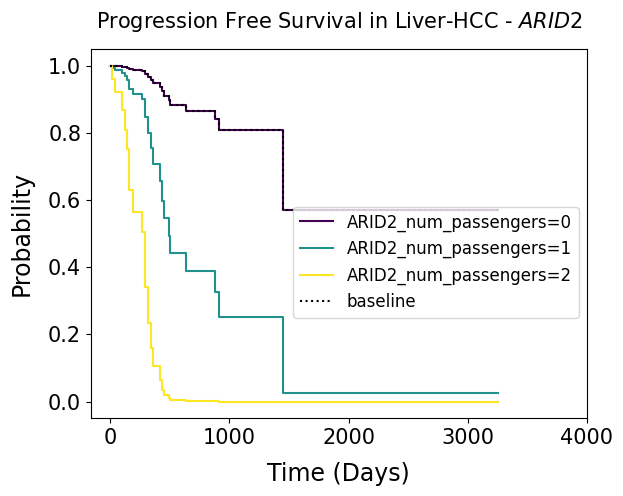

In [51]:
feature = "ARID2_num_passengers"
vals = model_data[feature].unique()
vals.sort()
vals = vals[~np.isnan(vals)]
vals = [int(val) for val in vals]
if len(vals) > 5:
	# get quartiles
	quintiles = np.percentile(vals, [0, 25, 50, 75, 100])
	print(quintiles)
plt.figure(figsize=(7, 6))
cph.plot_partial_effects_on_outcome(
    covariates=feature, 
    values=quintiles if len(vals) > 5 else vals,
    cmap="viridis",
    plot_baseline=True,
)
event_title = "Overall Survival" if event == "OS" else "Progression Free Survival"
plt.xlabel("Time (Days)", fontsize=17, labelpad=10)
plt.ylabel("Probability", fontsize=17, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15, ticks=np.arange(0, 4001, 1000)) # limit xticks to 5
plt.title(f"{event_title} in {cancer_type} - $\it{{{feature.split('_')[0]}}}$", fontsize=15, pad=15)
if len(vals) > 5:
	labels = ["Minimum", "Lower 25%", "Median", "Lower 75%", "Maximum", "Baseline"]
	# plt.legend(loc="lower right", labels=labels, fontsize=15, bbox_to_anchor=(1.43, 0.45))
	plt.legend(loc="lower right", labels=labels, fontsize=12, bbox_to_anchor=(1, 0.0))
else:
	# plt.legend(loc="lower right", fontsize=15, bbox_to_anchor=(1.2, 0.5))
	plt.legend(loc="lower right", fontsize=12, bbox_to_anchor=(1, 0.25))
plt.savefig(f"../results/PCAWG/partial_effects_{cancer_type}_{feature}.png", bbox_inches="tight", dpi=300)